# 定义扰动功能模块

In [19]:
import torch
torch.multiprocessing.set_start_method('spawn', force=True)

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

import numpy as np
from tqdm import tqdm

from models.ResNet import ResNet18
from util import AverageMeter

import random
import matplotlib.pyplot as plt
import matplotlib

import random
import matplotlib.pyplot as plt
import matplotlib

def imshow(img, trans=(0,1,2)):  # (32, 32, 3)
    fig = plt.figure(figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
    npimg = img.detach().cpu().numpy()
    transimg = np.transpose(npimg, trans)
    plt.imshow(transimg)
    plt.show()

CLASS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
clean_target_id = 7043
clean_label = torch.tensor([6,]).to(device)
INTENDED_LABELS = random.randint(0,9)
while INTENDED_LABELS == clean_label:
    INTENDED_LABELS = random.randint(0,9)
root = '../datasets/'
BATCH_SIZE = 16
NUM_POISON = 50

In [2]:
import numpy as np
import torch
from torch.autograd import Variable

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    

class PerturbationTool():
    def __init__(self, seed=0, epsilon=0.03137254901, num_steps=20, step_size=0.00784313725):
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.seed = seed
        np.random.seed(seed)

    def random_noise(self, noise_shape=[50, 32, 32, 3]):
        random_noise = torch.FloatTensor(*noise_shape).uniform_(-self.epsilon, self.epsilon).to(device)
        return random_noise

    def min_min_attack(self, images, labels, model, optimizer, criterion, random_noise=None, sample_wise=False):
        if random_noise is None:
            random_noise = torch.FloatTensor(*images.shape).uniform_(-self.epsilon, self.epsilon).to(device)
        
        images = images.reshape([1, 32, 32, 3])
        perturb_img = Variable(images.data + random_noise, requires_grad=True)
        perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)
        perturb_img = perturb_img.cuda().detach()
        perturb_img.requires_grad = True

        eta = random_noise
        for _ in range(self.num_steps):
            opt = torch.optim.SGD([perturb_img], lr=1e-3)
            opt.zero_grad()
            model.zero_grad()
            if isinstance(criterion, torch.nn.CrossEntropyLoss):
                if hasattr(model, 'classify'):
                    model.classify = True
                perturb_img = torch.tensor(np.transpose(perturb_img.detach().cpu().numpy(), (0, 3, 1, 2)), requires_grad=True).cuda()
                logits = model(perturb_img)
                logits = logits.view(-1, 1*10)
                if len(labels)==1:
                    labels = torch.tensor([lab for lab in labels for i in range(len(logits/10))]).cuda()
                else:
                    continue
                loss = criterion(logits, labels)
            else:
                logits, loss = criterion(model, perturb_img, labels, optimizer)    
            perturb_img.retain_grad()
            loss.backward()
            perturb_img_grad = perturb_img.grad.squeeze(0)
            perturb_img_grad = torch.tensor(np.transpose(perturb_img_grad.detach().cpu().numpy(), (1, 2, 0))).cuda()
            perturb_img_data = perturb_img.data.squeeze(0)
            perturb_img_data = torch.tensor(np.transpose(perturb_img_data.detach().cpu().numpy(), (1, 2, 0))).cuda()
            # print(perturb_img_data.shape)
            # print(perturb_img_grad.shape)
            # print(eta.shape)
            eta = (self.step_size * perturb_img_grad.data.sign() * (-1))
            perturb_img = Variable(perturb_img_data + eta, requires_grad=True)
            eta = torch.clamp(perturb_img.data - images.data, -self.epsilon, self.epsilon)
            perturb_img = Variable(images.data + eta, requires_grad=True)
            perturb_img = Variable(torch.clamp(perturb_img, 0, 1), requires_grad=True)

        return perturb_img, eta

    def _patch_noise_extend_to_img(self, noise, image_size=[3, 32, 32], patch_location='center'):
        c, h, w = image_size[0], image_size[1], image_size[2]
        mask = np.zeros((c, h, w), np.float32)
        x_len, y_len = noise.shape[1], noise.shape[1]

        if patch_location == 'center' or (h == w == x_len == y_len):
            x = h // 2
            y = w // 2
        elif patch_location == 'random':
            x = np.random.randint(x_len // 2, w - x_len // 2)
            y = np.random.randint(y_len // 2, h - y_len // 2)
        else:
            raise('Invalid patch location')

        x1 = np.clip(x - x_len // 2, 0, h)
        x2 = np.clip(x + x_len // 2, 0, h)
        y1 = np.clip(y - y_len // 2, 0, w)
        y2 = np.clip(y + y_len // 2, 0, w)
        if type(noise) is np.ndarray:
            pass
        else:
            mask[:, x1: x2, y1: y2] = noise.cpu().numpy()
        return ((x1, x2, y1, y2), torch.from_numpy(mask).to(device))



Files already downloaded and verified
Files already downloaded and verified


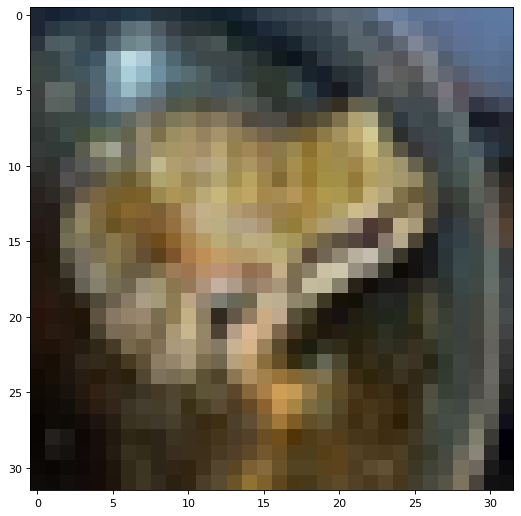

In [3]:
train_transform = [
    transforms.ToTensor()
]
test_transform = [
    transforms.ToTensor()
]
train_transform = transforms.Compose(train_transform)
test_transform = transforms.Compose(test_transform)

clean_train_dataset = datasets.CIFAR10(root, train=True, download=True, transform=train_transform)
clean_test_dataset = datasets.CIFAR10(root, train=False, download=True, transform=test_transform)

clean_train_loader = DataLoader(dataset=clean_train_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)
clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, pin_memory=True,
                                drop_last=False, num_workers=12)

clean_target = torch.tensor(clean_test_dataset.data[clean_target_id].astype(np.float32)/255).cuda()
imshow(clean_target)
# print(clean_target)

In [4]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms

import numpy as np
from tqdm import tqdm

from models.ResNet import ResNet18
from util import AverageMeter

import random
import matplotlib.pyplot as plt
import matplotlib

train_transform = [
        transforms.ToTensor()
    ]
train_transform = transforms.Compose(train_transform)

def find_similar_img(target, k=50):
    trainDataLoader = torch.utils.data.DataLoader(dataset=clean_train_dataset, batch_size=1)
    processBar = tqdm(trainDataLoader, unit='step')
    sims = {}
    for index, (trainImgs, labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        cos_sim = torch.nn.functional.cosine_similarity(target.flatten(), trainImgs.flatten(), dim=0)
        sims[index] = cos_sim
    sims = sorted(sims.items(), key=lambda x: x[1], reverse=True)
    # print(sims[:10])  # (9881, tensor(0.9158))
    # print(sims[0][0])  # 9881
    
    sim_group = []
    for i in range(k):
        sim_group.append(sims[i][0])

    return sim_group

def linear_interpolation(target_img, sim_id_group, alpha=0.9): 
    print(alpha)
    target_img = target_img.cuda().reshape([3,32,32])
    ip_img = []
    sim_img = []
    trainDataLoader = torch.utils.data.DataLoader(dataset=clean_train_dataset, batch_size=1)
    processBar = tqdm(trainDataLoader, unit='step')
    for index, (trainImgs, labels) in enumerate(processBar):
        if index in sim_id_group:
            sim_img.append(trainImgs)
            # img = torchvision.utils.make_grid(clean_train_dataset[index][0]).numpy()
            # plt.imshow(np.transpose(img,(1,2,0)))
            # plt.show()
    for img in sim_img: # img.1,3,32,32
        img = img.cuda().reshape([3,32,32])
        # print(target_img.shape)
        # print(img.shape)
        interpolation = alpha * target_img + (1-alpha) * img
        ip_img.append(interpolation.reshape([32,32,3]))
    ip_img = torch.tensor([img.cpu().detach().numpy() for img in ip_img]).cuda()
    return ip_img



In [5]:
def generate_noise(base_model, criterion, optimizer, interpolation_imgs, intended_labels, MAX_ITERATION=10):
    noise = torch.zeros([NUM_POISON, 32, 32, 3]).to(device)
    data_iter = iter(interpolation_imgs)
    target_labels = torch.tensor([intended_labels,]).to(device)
    condition = True
    train_idx = 0

    while condition:
        # optimize theta for M steps
        base_model.train()
        for param in base_model.parameters():
            param.requires_grad = True
        for j in range(0, MAX_ITERATION):
            try:
                images = next(data_iter)
            except:
                train_idx = 0
                data_iter = iter(interpolation_imgs)
                images = next(data_iter)
            
            for i, _ in enumerate(images):
                # Update noise to images
                images = images.reshape([1, 32, 32, 3])
                images += noise[train_idx]
                train_idx += 1 if train_idx != len(interpolation_imgs)-1 else 0
            images, target_labels = images.cuda(), target_labels.cuda()
            base_model.zero_grad()
            optimizer.zero_grad()
            trans_img = np.transpose(images.detach().cpu().numpy(), (0, 3, 1, 2))
            logits = base_model(torch.tensor(trans_img).cuda())
            loss = criterion(logits, target_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(base_model.parameters(), 5.0)
            optimizer.step()
        
        # Perturbation over entire interpolation_imgs
        idx = 0
        for param in base_model.parameters():
            param.requires_grad = False
        
        perturb_img_list = []
        for i, (images) in tqdm(enumerate(interpolation_imgs), total=len(interpolation_imgs)):
            perturb_img, eta = noise_generator.min_min_attack(images, target_labels, base_model, optimizer, criterion)
            perturb_img_list.append(perturb_img.clone().detach().cpu())
        for i, delta in enumerate(eta):
            # print(noise.shape)
            # print(delta.shape)
            noise[i] = delta.clone().detach().cpu()
            
            
        # Eval stop condition
        eval_idx, total, correct = 0, 0, 0
        for i, (images) in enumerate(interpolation_imgs):
            for i, _ in enumerate(images):
                # Update noise to images
                images = images + noise[eval_idx]
                eval_idx += 1 if eval_idx != len(interpolation_imgs)-1 else 0
            images, target_labels = images.cuda(), target_labels.cuda()
            images = torch.tensor(np.transpose(images.detach().cpu().numpy(), (2, 0, 1)), requires_grad=True).cuda()
            images = images.unsqueeze(0)
            # print(images.shape)
            with torch.no_grad():
                logits = base_model(images)
                _, predicted = torch.max(logits.data, 1)
                total += target_labels.size(0)
                correct += (predicted == target_labels).sum().item()
        acc = correct / total
        print('Accuracy %.4f' % (acc*100))
        if acc > 0.9500:
            condition=False     
            
    perturb_img_list = torch.tensor([img.cpu().detach().numpy() for img in perturb_img_list]).cuda().float()
    noise = torch.tensor([img.cpu().detach().numpy() for img in noise]).cuda().float()
    
    return perturb_img_list, noise

# 初始化设置

In [6]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

base_model = ResNet18()
base_model = base_model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=base_model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)

noise_generator = PerturbationTool(epsilon=0.03137254901960784, num_steps=20, step_size=0.0031372549019607846)

# 从训练集中找出相似度较高的图像

In [7]:
similar_imgs = find_similar_img(clean_target, NUM_POISON)

100%|██████████| 50000/50000 [00:24<00:00, 2000.37step/s]


# 线性插值，创建毒物集并加入扰动

In [8]:
interpolation_imgs = linear_interpolation(clean_target, similar_imgs, alpha=0.5)  # clean_target:0-1
# print(interpolation_imgs.shape)

0.5


100%|██████████| 50000/50000 [00:13<00:00, 3655.92step/s]
/tmp/ipykernel_291/1872288825.py:59: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /home/mist/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  ip_img = torch.tensor([img.cpu().detach().numpy() for img in ip_img]).cuda()


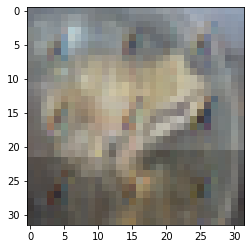

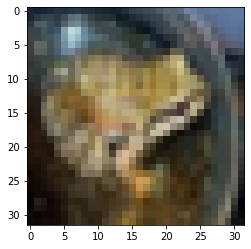

In [9]:
ip_img = interpolation_imgs[0].detach().cpu().numpy()
target_img = clean_target.detach().cpu().numpy()
plt.imshow(np.transpose(ip_img,(0,1,2)))
plt.show()
plt.imshow(np.transpose(target_img,(0,1,2)))
plt.show()

In [10]:
def create_poison_data(new_imgs):
    poison_dataset = torch.tensor([img.cpu().detach().numpy() for img in new_imgs]).cuda()
    for i in range(len(poison_dataset)):
        poison_dataset.data[i] = torch.clamp(poison_dataset.data[i], 0, 1)
    return poison_dataset.cuda()

raw_dataset = create_poison_data(interpolation_imgs) # 0-1
perturb_img_list, noise = generate_noise(base_model, criterion, optimizer, raw_dataset, intended_labels=torch.tensor(INTENDED_LABELS), MAX_ITERATION=10)

100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


Accuracy 100.0000


torch.Size([50, 1, 32, 32, 3]) ->perturb_img_list
torch.Size([32, 32, 3]) ->test_img


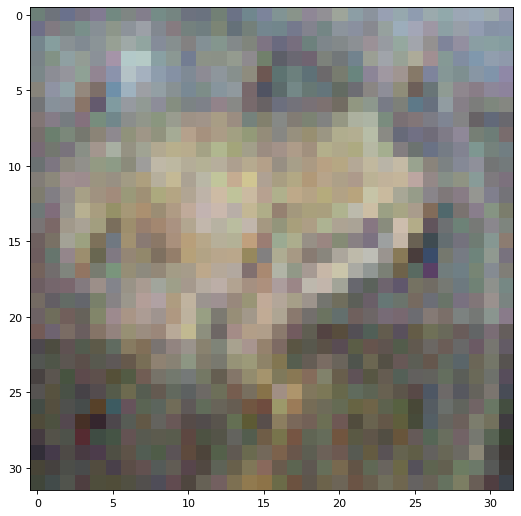

In [11]:
# perturb_img_list = perturb_img_list.squeeze(1)
print(perturb_img_list.shape, '->perturb_img_list')
test_img = perturb_img_list[0].squeeze(0)
print(test_img.shape, '->test_img')
imshow(test_img)

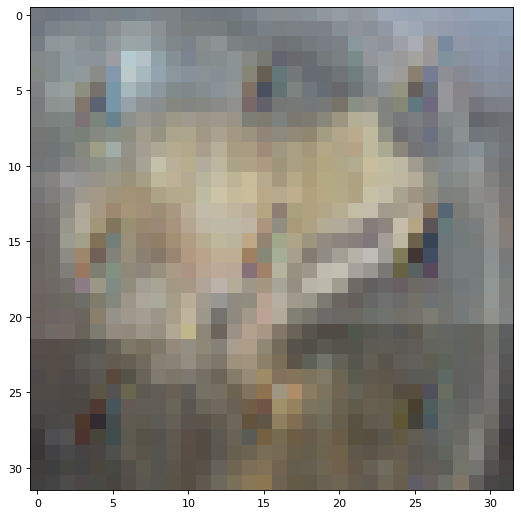

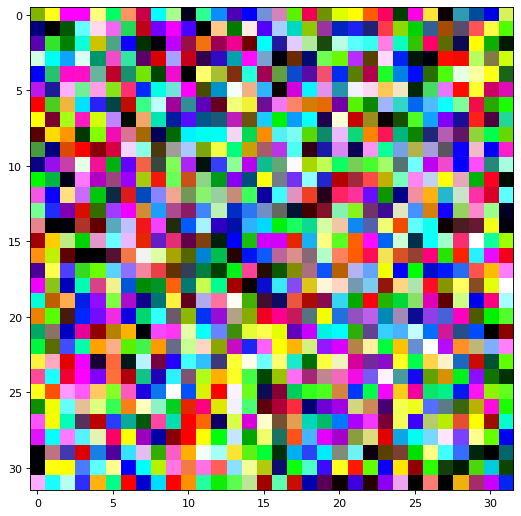

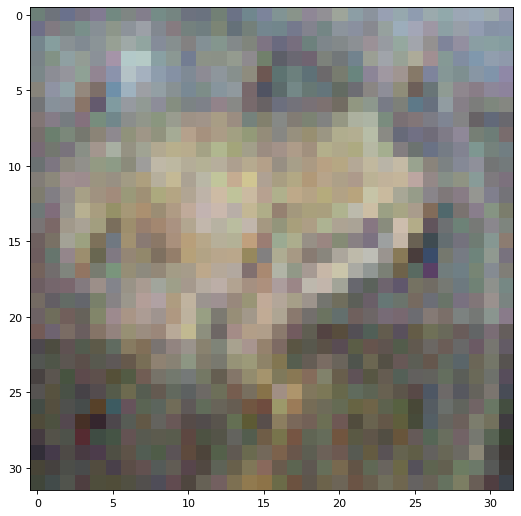

In [12]:
import random
import matplotlib.pyplot as plt
import matplotlib
    
def get_pairs_of_imgs(idx):
    clean_img = interpolation_imgs.data[idx]
    unlearnable_img = perturb_img_list.data[idx].squeeze(0)

    x = noise[idx]
    x_min = torch.min(x)
    x_max = torch.max(x)
    noise_norm = (x - x_min) / (x_max - x_min)
    noise_norm = torch.clamp(noise_norm, 0, 1)
    # print(clean_img.cuda().shape, noise_norm.shape, unlearnable_img.shape)
    return [clean_img.cuda(), noise_norm, unlearnable_img]
    
selected_idx = [0]
img_grid = []
for idx in selected_idx:
    img_grid += get_pairs_of_imgs(idx)
    
for img in img_grid:
    imshow(img)
    
# imshow(torchvision.utils.make_grid(torch.stack(img_grid), nrow=3, pad_value=255))

In [13]:
total_succ = 0
for i in range(NUM_POISON):
    temp = perturb_img_list[i].squeeze(0).clone().detach().cpu().numpy()
    temp = np.transpose(temp, (2, 0, 1))
    temp = torch.tensor(temp).cuda().unsqueeze(0)
    logits = base_model(temp)
    _, predicted = torch.max(logits.data, 1)
    result = CLASS[int(predicted)]
    if result == CLASS[INTENDED_LABELS]:
        total_succ += 1
accuracy = total_succ/NUM_POISON
print('Original label: {} -> Poisoned label: {}'.format(CLASS[clean_label].capitalize(), CLASS[INTENDED_LABELS].capitalize()))
print('Universal single poison accuracy: {}%'.format(accuracy*100))

if accuracy > 0.95:
    torch.save(perturb_img_list, "./perturb_img_{}_{}.pt".format(clean_target_id, INTENDED_LABELS))

Original label: Frog -> Poisoned label: Airplane
Universal single poison accuracy: 100.0%


In [14]:
from torch.utils.data.dataset import Dataset
from torchvision import transforms

class UnlearnableDataset(Dataset):
    def __init__(self, label):
        self.label = label
        train_transform = [
            # transforms.ToTensor()
        ]
        self.transformations = transforms.Compose(train_transform)
        
    def __getitem__(self, index):
        data = torch.load("./perturb_img_{}_{}.pt".format(clean_target_id, INTENDED_LABELS))
        data = self.transformations(data)
        img = data[index]
        return (img, self.label)
 
    def __len__(self):
        return NUM_POISON
        
unlearnable_dataset = UnlearnableDataset(INTENDED_LABELS)

In [17]:
def train_new_poisoned_model(unlearnable_dataset, MAX_EPOCH=20, BATCH_SIZE=128):
    model = ResNet18()
    model = model.cuda()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1, weight_decay=0.0005, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=0)

    unlearnable_loader = DataLoader(unlearnable_dataset, batch_size=BATCH_SIZE,
                                    shuffle=True, pin_memory=True,
                                    drop_last=False, num_workers=12)
    clean_train_dataset = datasets.CIFAR10(root, train=True, download=True, transform=train_transform)
    clean_loader = DataLoader(clean_train_dataset, batch_size=BATCH_SIZE,
                                    shuffle=True, pin_memory=True,
                                    drop_last=False, num_workers=12)
    clean_test_dataset = datasets.CIFAR10(root, train=False, download=True, transform=test_transform)
    clean_test_loader = DataLoader(dataset=clean_test_dataset, batch_size=BATCH_SIZE,
                                    shuffle=False, pin_memory=True,
                                    drop_last=False, num_workers=12)
    
    for epoch in range(MAX_EPOCH):
        model.train()
        acc_meter = AverageMeter()
        loss_meter = AverageMeter()
        # pbar = tqdm([unlearnable_loader, clean_loader], total=len(unlearnable_loader)+len(clean_loader))
        # pbar = tqdm(clean_loader, total=len(clean_loader))
        pbar = tqdm(unlearnable_loader, total=len(unlearnable_loader))
        for images, labels in pbar:
            images, labels = images.cuda(), labels.cuda()
            model.zero_grad()
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            
            _, predicted = torch.max(logits.data, 1)
            acc = (predicted == labels).sum().item()/labels.size(0)
            acc_meter.update(acc)
            loss_meter.update(loss.item())
            pbar.set_description("Acc %.4f Loss: %.4f" % (acc_meter.avg*100, loss_meter.avg))
        scheduler.step()
        # Eval
        model.eval()
        correct, total = 0, 0
        for i, (images, labels) in enumerate(clean_test_loader):
            images, labels = images.cuda(), labels.cuda()
            with torch.no_grad():
                logits = model(images)
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = correct / total
        tqdm.write('Clean Accuracy %.4f' % (acc*100))
        # Test target class
        # imshow(torch.tensor(clean_test_dataset.data[clean_target_id]).to(device))
        target = torch.tensor(np.transpose(clean_test_dataset.data[clean_target_id], (2, 0, 1))).to(device).unsqueeze(0).float()
        with torch.no_grad():
            logits = model(target)
            # print(logits)
            _, predicted = torch.max(logits.data, dim=1)
            print('Current epoch: {}, Clean class: {}, Expected class: {}, Predicted class: {}'.format(epoch+1, CLASS[clean_label] , CLASS[INTENDED_LABELS], CLASS[int(predicted)]))
    return predicted

In [21]:
pred = train_new_poisoned_model(unlearnable_dataset, MAX_EPOCH=10, BATCH_SIZE=1)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/50 [00:00<?, ?it/s]Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UnlearnableDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UnlearnableDataset' on <module '__main__' (built-in)>
  0%|          | 0/50 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 4583) exited unexpectedly

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UnlearnableDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'UnlearnableDataset' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel